In [ ]:
# © 2025 M26I - For educational/portfolio use only
import numpy as np
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt

# Load dataset
iris = load_iris()
X = iris.data
y = iris.target.reshape(-1, 1)

# Normalize features
X = (X - X.mean(axis=0)) / X.std(axis=0)

# One-hot encode target
encoder = OneHotEncoder(sparse_output=False)
y_encoded = encoder.fit_transform(y)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42
)

# Also keep class labels for evaluation
y_test_labels = np.argmax(y_test, axis=1)


In [5]:
class NeuralNetwork:
    def __init__(self, input_size, hidden_size, output_size, learning_rate=0.05):
        self.W1 = np.random.randn(input_size, hidden_size) * np.sqrt(2. / input_size)
        self.b1 = np.zeros((1, hidden_size))
        self.W2 = np.random.randn(hidden_size, output_size) * np.sqrt(2. / hidden_size)
        self.b2 = np.zeros((1, output_size))
        self.learning_rate = learning_rate
        self.loss_history = []

    def relu(self, x):
        return np.maximum(0, x)

    def relu_derivative(self, x):
        return x > 0

    def softmax(self, x):
        exp_scores = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

    def forward(self, X):
        self.z1 = X @ self.W1 + self.b1
        self.a1 = self.relu(self.z1)
        self.z2 = self.a1 @ self.W2 + self.b2
        self.a2 = self.softmax(self.z2)
        return self.a2

    def compute_loss(self, y_pred, y_true):
        m = y_true.shape[0]
        return -np.sum(y_true * np.log(y_pred + 1e-8)) / m

    def backward(self, X, y_true):
        m = y_true.shape[0]
        error_output = self.a2 - y_true
        dW2 = self.a1.T @ error_output / m
        db2 = np.sum(error_output, axis=0, keepdims=True) / m

        error_hidden = error_output @ self.W2.T * self.relu_derivative(self.a1)
        dW1 = X.T @ error_hidden / m
        db1 = np.sum(error_hidden, axis=0, keepdims=True) / m

        self.W2 -= self.learning_rate * dW2
        self.b2 -= self.learning_rate * db2
        self.W1 -= self.learning_rate * dW1
        self.b1 -= self.learning_rate * db1

    def train(self, X, y, epochs=1000):
        for epoch in range(1, epochs + 1):
            y_pred = self.forward(X)
            loss = self.compute_loss(y_pred, y)
            self.loss_history.append(loss)
            self.backward(X, y)
            if epoch % 100 == 0:
                print(f"Epoch {epoch}, Loss: {loss:.4f}")

    def predict(self, X):
        probs = self.forward(X)
        return np.argmax(probs, axis=1)

    def evaluate(self, X, y_true_labels):
        y_pred_labels = self.predict(X)
        acc = np.mean(y_pred_labels == y_true_labels)
        print(f"Test Accuracy: {acc * 100:.2f}%")
        return acc
        
# Train from-scratch NN
nn = NeuralNetwork(input_size=4, hidden_size=6, output_size=3, learning_rate=0.05)
nn.train(X_train, y_train, epochs=2000)
nn.evaluate(X_test, y_test_labels)

# Save predictions
np.save("scratch_predictions.npy", nn.predict(X_test))
np.save("loss_manual.npy", nn.loss_history)


Epoch 100, Loss: 0.3789
Epoch 200, Loss: 0.2842
Epoch 300, Loss: 0.2340
Epoch 400, Loss: 0.1972
Epoch 500, Loss: 0.1691
Epoch 600, Loss: 0.1483
Epoch 700, Loss: 0.1319
Epoch 800, Loss: 0.1184
Epoch 900, Loss: 0.1084
Epoch 1000, Loss: 0.0994
Epoch 1100, Loss: 0.0920
Epoch 1200, Loss: 0.0862
Epoch 1300, Loss: 0.0816
Epoch 1400, Loss: 0.0774
Epoch 1500, Loss: 0.0727
Epoch 1600, Loss: 0.0686
Epoch 1700, Loss: 0.0658
Epoch 1800, Loss: 0.0639
Epoch 1900, Loss: 0.0623
Epoch 2000, Loss: 0.0609
Test Accuracy: 96.67%


In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class IrisNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(4, 6)
        self.fc2 = nn.Linear(6, 3)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return F.log_softmax(self.fc2(x), dim=1)


In [7]:
# Prepare PyTorch data
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(np.argmax(y_train, axis=1), dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

model = IrisNet()
criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.05)

losses = []
for epoch in range(1000):
    model.train()
    optimizer.zero_grad()
    output = model(X_train_tensor)
    loss = criterion(output, y_train_tensor)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")


Epoch 0, Loss: 0.9934
Epoch 100, Loss: 0.0454
Epoch 200, Loss: 0.0435
Epoch 300, Loss: 0.0432
Epoch 400, Loss: 0.0430
Epoch 500, Loss: 0.0429
Epoch 600, Loss: 0.0428
Epoch 700, Loss: 0.0428
Epoch 800, Loss: 0.0428
Epoch 900, Loss: 0.0428


In [8]:
# Save PyTorch predictions
model.eval()
with torch.no_grad():
    pytorch_preds = model(X_test_tensor).argmax(dim=1).numpy()
np.save("pytorch_predictions.npy", pytorch_preds)
np.save("loss_pytorch.npy", losses)


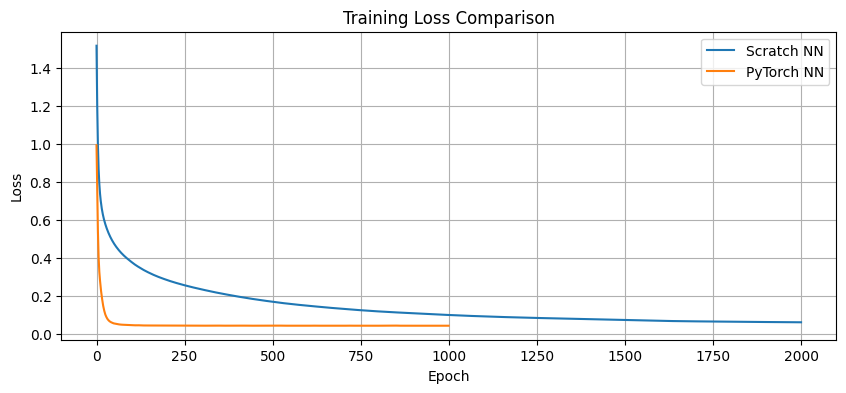

In [9]:
loss_manual = np.load("loss_manual.npy")
loss_pytorch = np.load("loss_pytorch.npy")

plt.figure(figsize=(10, 4))
plt.plot(loss_manual, label="Scratch NN")
plt.plot(loss_pytorch, label="PyTorch NN")
plt.title("Training Loss Comparison")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()


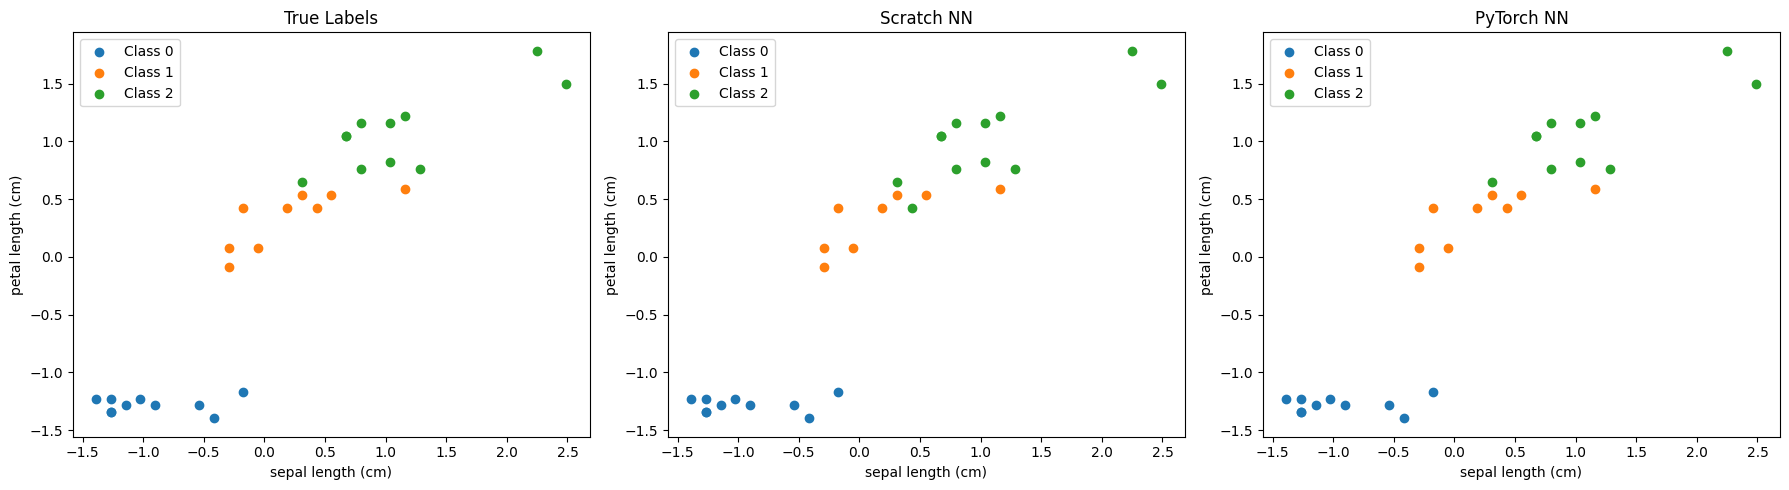

In [10]:
scratch_preds = np.load("scratch_predictions.npy")
pytorch_preds = np.load("pytorch_predictions.npy")

feature_x, feature_y = 0, 2  # sepal length vs petal length

plt.figure(figsize=(18, 5))

titles = ["True Labels", "Scratch NN", "PyTorch NN"]
preds = [y_test_labels, scratch_preds, pytorch_preds]

for i in range(3):
    plt.subplot(1, 3, i + 1)
    for label in range(3):
        idx = preds[i] == label
        plt.scatter(X_test[idx, feature_x], X_test[idx, feature_y], label=f"Class {label}")
    plt.title(titles[i])
    plt.xlabel(iris.feature_names[feature_x])
    plt.ylabel(iris.feature_names[feature_y])
    plt.legend()

plt.tight_layout()
plt.show()
